# An example for testing MODSIM - MF6 integration using BMI interface
This problem first appeared in [Morway et al. (2016)](https://www.sciencedirect.com/science/article/pii/S136481521630113X) and is patterned after an irrigated river valley.  Advanced package options include a reservoir, 4 major diversions, simulation of the unsaturated zone, and the use of Mover to shunt water between packages. In addition, this example uses the MODFLOW 6 BMI to interact with MODSIM which is a river operations model.  The use of MODSIM enables reservoir releases and priority-based (or rule-based) diversions to be set dynamically while the model is running.  In addition, MODSIM enforces a minimum instream flow requirement at the bottom of the system as the most senior "water-right," and as such, it will curtail upstream diversions as necessary in order to meet the minimum instream flow requirement.

![MODSIM-MODFLOW6 hypothetical model](./modsim_model_view.png)

### Import flopy for constructing, running, and post-processing the test problem

In [1]:
# Append to system path to include the common subdirectory
import os
import sys
sys.path.append(os.path.join("common"))
sys.path.append(os.path.join("..", "bin"))

#### Imports

In [2]:
import flopy
import shutil
import numpy as np
import pandas as pd
import config
from figspecs import USGSFigure
from flopy.utils.util_array import read1d
import flopy.utils.binaryfile as bf
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from datetime import datetime
from matplotlib.path import Path

In [3]:
sys.path.append(os.path.join("modsim_data"))
import build_modsim_helper_funcs as modsimBld

mf6exe = os.path.abspath(config.mf6_exe)
assert os.path.isfile(mf6exe)
print(mf6exe)
exe_name_mf = config.mf2005_exe
exe_name_mt = config.mt3dms_exe

# Set figure properties specific to this problem
figure_size = (6, 4.5)
fs = USGSFigure(figure_type="graph")

# Base simulation and model name and workspace
ws = config.base_ws
example_name = "modsim"


D:\edm_lt\github\mf6_dev\mf6bmi_paper.git\models\bin\mf6.exe


c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Model units

In [4]:
length_units = "meters"
time_units = "days"

c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Table of values

In [5]:
nlay = 4       # Number of layers
nrow = 64      # Number of rows
ncol = 133     # Number of columns
delr = 400.0   # Column width ($m$)
delc = 400.0   # Row width ($m$)
prsity = 0.3   # Porosity
perlen = 365   # Simulation time ($days$)
k11 = 10.0     # Horizontal hydraulic conductivity ($m/d$)
k33 = 2.0      # Vertical hydraulic conductivity ($m/d$)
Ss  = 1e-6     # Storativity
sy_1 = 0.28    # Specific yield and porosity of layer 1
sy_2 = 0.30    # Specific yield and porosity of layer 2
sy_3 = 0.32    # Specific yield and porosity of layer 3
sy_4 = 0.34    # Specific yield and porosity of layer 4
surfdep = 0.5  # Land-surface depression ($m$)
vks  = 0.12    # Saturated hydraulic conductivity of unsaturated zone ($m/d$)
thtr = 0.05    # Residual water content
thts = 0.42    # Saturated water content
thti = 0.15    # Initial water content (unsaturated zone)
eps  = 7.1     # Brooks-Corey epsilon
al = 2.        # Longitudinal dispersivity ($m$)
rhob_1 = 1.5   # Bulk density of layer 1 ($g/cm^3$)
rhob_2 = 1.7   # Bulk density of layer 2 ($g/cm^3$)
rhob_3 = 1.8   # Bulk density of layer 3 ($g/cm^3$)
rhob_4 = 1.9   # Bulk density of layer 4 ($g/cm^3$)
Kd =  0.176    # Distribution coefficient ($cm^3/g$)


c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Additional model input

In [6]:
# Time related
rng     = pd.date_range(start='10/1/1989', end='10/1/1990')
numdays = 366
perlen  = [1] * numdays
nper    = len(perlen)
nstp    = [1] * numdays
tsmult  = [1.] * numdays
# UZF related
nuztop  = 3
iuzfopt = 1
irunflg = 1
ietflg  = 1
iuzfcb1 = -40
iuzfcb2 = 0
ntrail2 = 10
nsets2  = 50
iuzfbnd = np.loadtxt(os.path.join('modsim_data','uzf_support','iuzfbnd.txt'))
ha = 0.
hroot = 0.
rootact = 0.
finf_ss  = 0.0001    # 0.1 mm
pet_ss   = 0.002     # 2.0 mm
extdp_ss = 5.4864    # m (18 ft)
extwc_ss = 0.08
extdp = extdp_ss
extwc = extwc_ss

c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
icelltype = 1
iconvert = 1
sy_1 = np.ones((nrow, ncol)) * sy_1
sy_2 = np.ones((nrow, ncol)) * sy_2
sy_3 = np.ones((nrow, ncol)) * sy_3
sy_4 = np.ones((nrow, ncol)) * sy_4
sy = [sy_1, sy_2, sy_3, sy_4]
poro_1 = sy_1.copy()
poro_2 = sy_2.copy()
poro_3 = sy_3.copy()
poro_4 = sy_4.copy()
prsity = [poro_1, poro_2, poro_3, poro_4]


c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Model geometry and Active model domain

In [8]:
top  = np.loadtxt(os.path.join('modsim_data','dis_support','top1.txt'))
bot1 = np.loadtxt(os.path.join('modsim_data','dis_support','bot1.txt'))
bot2 = np.loadtxt(os.path.join('modsim_data','dis_support','bot2.txt'))
bot3 = np.loadtxt(os.path.join('modsim_data','dis_support','bot3.txt'))
bot4 = np.loadtxt(os.path.join('modsim_data','dis_support','bot4.txt'))
botm = [bot1, bot2, bot3, bot4]
botm_np = np.array(botm)


ibnd1 = np.loadtxt(os.path.join('modsim_data','bas_support','ibnd1.txt'))
ibnd2 = np.loadtxt(os.path.join('modsim_data','bas_support','ibnd2.txt'))
ibnd3 = np.loadtxt(os.path.join('modsim_data','bas_support','ibnd3.txt'))
ibnd4 = np.loadtxt(os.path.join('modsim_data','bas_support','ibnd4.txt'))
ibnda = np.array([ibnd1, ibnd2, ibnd3, ibnd4])
strt1 = np.loadtxt(os.path.join('modsim_data','bas_support','strt.txt'))
strt  = [strt1, strt1, strt1, strt1]

# Set some of the storage parameters
# if using 1.5 g/cm^3 (layer 1), unit conversion is 100cm x 100cm x 100cm / 1m^3 = 1e6 g/m^3
rhob_1 = np.ones_like(poro_1) * rhob_1 * 1e6
rhob_2 = np.ones_like(poro_2) * rhob_2 * 1e6
rhob_3 = np.ones_like(poro_3) * rhob_3 * 1e6
rhob_4 = np.ones_like(poro_4) * rhob_4 * 1e6
rhob   = [rhob_1, rhob_2, rhob_3, rhob_4]
# Kd: "Distribution coefficient"
# if using 0.176 cm^3/g, unit conversion is 1m^3 / (100cm x 100cm x 100cm) = 1e-6 m^3/g
Kd_1   = np.ones_like(poro_1) * Kd * 1e-6
Kd_2   = np.ones_like(poro_2) * Kd * 1e-6
Kd_3   = np.ones_like(poro_3) * Kd * 1e-6
Kd_4   = np.ones_like(poro_4) * Kd * 1e-6
Kd     = [Kd_1, Kd_2, Kd_3, Kd_4]


c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Set solver parameter values (and related)
nouter, ninner = 100, 300              
hclose, rclose, relax = 1e-2, 1e2, 0.97

c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Some variables that are needed globally
iuzno_cell_dict = {}  # Setting up a dictionary to help with SFR -> UZF connections in the next sub-section
iuzno_dict_rev  = {}

c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Function to build models

In [11]:
def build_model(sim_name, silent=False):
    if config.buildModel:
        
        # MODFLOW 6
        name = 'modsim'
        sim_ws = os.path.join(ws, sim_name)
        sim = flopy.mf6.MFSimulation(sim_name=sim_name, 
                                     sim_ws=sim_ws, 
                                     exe_name=mf6exe,
                                     memory_print_option="ALL",
                                     continue_=True
        )
        
        # Instantiating MODFLOW 6 time discretization
        tdis_rc = []
        for i in range(len(rng)):
            tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
        flopy.mf6.ModflowTdis(sim, 
                              nper=nper, 
                              perioddata=tdis_rc, 
                              time_units=time_units
        )
        
        # Instantiating MODFLOW 6 groundwater flow model
        gwfname = 'gwf_' + name
        gwf = flopy.mf6.ModflowGwf(sim,
                                   modelname=gwfname,
                                   save_flows=True,
                                   newtonoptions="NEWTON UNDER_RELAXATION",
                                   model_nam_file='{}.nam'.format(gwfname)
        )
        
        # Instantiating MODFLOW 6 solver for flow model
        imsgwf = flopy.mf6.ModflowIms(sim,
                                      print_option="summary",
                                      #complexity="complex",
                                      outer_dvclose=1.0e-2,
                                      outer_maximum=2000,
                                      under_relaxation="cooley",
                                      linear_acceleration="BICGSTAB",
                                      under_relaxation_theta=0.3,
                                      under_relaxation_kappa=0.08,
                                      under_relaxation_gamma=0.08,
                                      under_relaxation_momentum=0.01,
                                      #backtracking_number=20,
                                      #backtracking_tolerance=2.0,
                                      #backtracking_reduction_factor=0.2,
                                      #backtracking_residual_limit=5.0e-4,
                                      inner_dvclose=1.0e-3,
                                      rcloserecord=[0.0001, "relative_rclose"],
                                      inner_maximum=100,
                                      relaxation_factor=0.0,
                                      number_orthogonalizations=2,
                                      preconditioner_levels=8,
                                      preconditioner_drop_tolerance=0.001,
                                      filename='{}.ims'.format(gwfname)
        )
        sim.register_ims_package(imsgwf, [gwf.name])
        
        # Instantiating MODFLOW 6 discretization package
        flopy.mf6.ModflowGwfdis(gwf,
                                length_units=length_units,
                                nlay=nlay,
                                nrow=nrow,
                                ncol=ncol,
                                delr=delr,
                                delc=delc,
                                top=top,
                                botm=botm,
                                idomain=ibnda,
                                filename='{}.dis'.format(gwfname)
        )
        
        # Instantiating MODFLOW 6 node-property flow package
        flopy.mf6.ModflowGwfnpf(gwf,
                                save_flows=False,
                                icelltype=icelltype, 
                                k=k11, 
                                k33=k33,
                                save_specific_discharge = True,
                                filename='{}.npf'.format(gwfname)
        )
        
        # Instantiating MODFLOW 6 initial conditions package for flow model
        flopy.mf6.ModflowGwfic(gwf, 
                               strt=strt,
                               filename='{}.ic'.format(gwfname)
        )
        
        # Instantiate MODFLOW 6 storage package 
        flopy.mf6.ModflowGwfsto(gwf, 
                                ss=Ss, 
                                sy=sy,
                                iconvert=iconvert,
                                steady_state={0:True},
                                transient={1:True},
                                filename='{}.sto'.format(gwfname)
        )
        
        # Instantiating MODFLOW 6 output control package for flow model
        flopy.mf6.ModflowGwfoc(gwf,
                               head_filerecord="{}.hds".format(gwfname),
                               budget_filerecord="{}.bud".format(gwfname),
                               headprintrecord=[
                                                ('COLUMNS', 10, 'WIDTH', 15,
                                                 'DIGITS', 6, 'GENERAL')],
                               saverecord=[('HEAD', 'LAST'),
                                           ('BUDGET', 'LAST')],
                               printrecord=[('HEAD', 'LAST'),
                                            ('BUDGET', 'LAST')]
        )
        
        # Instantiate starting concentration arrays:
        # Need to instantiate the starting concentration array here because the RCHA package (next) uses the starting concentration array to set the concentration of recharge occurring on the perimeter of the model. RCHA assigns the concentration of the recharge using an auxiliary array
        #
        # For initial concentrations, start with a back-ground salt (TDS) concentration typical of a salinized ag system to provide some variation, setup a gradient of increasing concentrations from lowerleft to upperright, then mirror, and finally splice together the upper and lower halves of the two arrays, respectively.
        Lx = (ncol - 1) * delr
        Ly = (nrow - 1) * delc
        Ls = np.sqrt(Lx ** 2 + Ly ** 2) - 40000
        grad = 0.05
        c1 = grad * Ls
        a = -1
        b = -1
        c = 1
        x = gwf.modelgrid.xcellcenters
        y = gwf.modelgrid.ycellcenters
        d = abs(a*x + b*y + c) / np.sqrt(2)
        conc_grad_lower = c1 + d / Ls * c1
        conc_grad_upper = np.flipud(conc_grad_lower).copy()
        strt_conc = conc_grad_upper.copy()
        strt_conc[32:63, :] = conc_grad_lower[32:63, :].copy()
        strta = np.array([strt_conc, strt_conc, strt_conc, strt_conc])
        
        # Instantiating MODFLOW 6 array-based recharge package (with a concentration auxiliary array above)
        # The RCH package is intended to simulate a small regional groundwater inflow from surrounding lands. Because the modeled area is patterned after an irrigated river valley, surrounding non-irrigated associated with semi-arid to arid regions are not explicitly represented by the model, though they may contribute small amounts of water along the northern and southern perimeter of active model domain. The concentration associated with this regional groundwater inflow has abitrarily been set to a low background concentration.
        ss_rch   = np.loadtxt(os.path.join('modsim_data','rch_support','ss_rch.txt'))
        tr_rch   = np.loadtxt(os.path.join('modsim_data','rch_support','tr_rch.txt'))
        
        # Initialize a concentration array by grabbing the starting concentration array values
        # When passing the RCHA constructor, the auxiliary concentration array needs to be 3d w/ 1 layer.
        rch_conc = np.zeros((1,64,133))
        rch_conc[0,:,:] = strta[3,:,:].copy() * 0.5
        rch_conc[0, tr_rch == 0] = 0.
        irch = {0: 3, 1: 3}  
        recharge = {0: ss_rch, 1:tr_rch}
        rchc = {0: rch_conc, 1: rch_conc}
        
        flopy.mf6.ModflowGwfrcha(gwf, 
                                 readasarrays=True,
                                 auxiliary='CONCENTRATION',
                                 pname='RCH-1', 
                                 fixed_cell=False, 
                                 print_input=False, 
                                 irch=irch, 
                                 recharge=recharge,
                                 aux=rchc,
                                 filename='{}.rcha'.format(gwfname)
        )
        
        # Instantiating MODFLOW 6 DRN package (with a concentration auxiliary variable)
        # Here, the drain (DRN) package is used to simulate groundwater discharge to land surface to keep this water separate from rejected infiltrated simulated by the UZF package. From a transport perspective, these two sources of water can have very different concentrations, and therefore very different contributions of mass to nearby surface waters, whether streams, open drains simulated using the stream package, or lakes and ponds simulated with the LAK package. Movement of both rejected infiltration and groundwater discharge to land surface to the surface water system will be handled by the MVR package
        # Rejected infiltration: uzf -> mvr -> sfr/lak
        # Groundwater discharge to land surface: drn -> mvr -> sfr/lak
        # Need to cycle through all land surface cells and create a drain for handling groundwater discharge to land surface
        drn_spd  = []
        drn_dict = {}
        cond     = 38400  # Use an arbitrarily high conductance term to avoid impeding groundwater discharge
        ddrn     = -0.5   # See definition of auxdepthname in drain package documentation to learn more about this parameter
        idrnno   = 0
        for i in np.arange(0, top.shape[0]):
            for j in np.arange(0, top.shape[1]):
                if ibnda[0,i,j]:
                    drn_spd.append([(0,i,j), top[i, j], cond, ddrn, 0.0])  #  'ddrn',
                    # append dictionary of drain indices
                    drn_dict.update({(i,j): idrnno})
                    idrnno += 1
        
        maxbound = len(drn_spd)   # The total number 
        spd = {0: drn_spd}
        flopy.mf6.ModflowGwfdrn(gwf, pname='DRN-1',
                                auxiliary=['ddrn', 'CONCENTRATION'],
                                auxdepthname='ddrn',
                                print_input=False, 
                                print_flows=False,
                                maxbound=maxbound,
                                mover=True,
                                stress_period_data=spd,   # wel_spd established in the MVR setup
                                boundnames=False, 
                                save_flows=True,
                                filename='{}.drn'.format(gwfname)
        )
        
        # Start of Advanced Package Instantiation
        # * Unsaturated Zone Flow Package
        # * Streamflow Routing Package
        # * Lake Package
        # * Mover Package
        #
        # Instantiating MODFLOW 6 unsatruated-zone flow package
        # The datasets relied upon to create the UZF input are from the original UZF input file for MF-NWT. As such, 1 year's worth of pET arrays were peeled out of the original UZF input file and stored as 2D arrays, 1 file per day. The pET information varies cell-by-cell and is based on an annually varying cropping pattern, with 5 different crop types. I believe the original publication contains more information about the pET values. Precipitation data also was stored in the original UZF input file, and these values will be entered here as well.
        # Fill 3D numpy array with every cell's total uz storage (used for post-processing later)
        uzMaxStor = np.zeros_like(ibnda)
        cell_area = delr * delc
        uz_voids  = (thts - thtr)
        for k in np.arange(uzMaxStor.shape[0]):
            for i in np.arange(uzMaxStor.shape[1]):
                for j in np.arange(uzMaxStor.shape[2]):
                    if ibnda[k, i, j] > 0:
                        if k==0:
                            cel_thkness = top[i, j] - botm_np[0, i, j]
                        else:
                            cel_thkness = botm_np[k-1, i, j] - botm_np[k, i, j]
                        uzMaxStor[k, i, j] = cell_area * uz_voids * cel_thkness
        
        # UZF Boundname support 
        # ----------------------
        fl = os.path.join('modsim_data','sfr_support')  
        sfr2uzf = pd.read_csv(os.path.join(fl,'sfr_2_uzf_conns.csv'), header=0)
        
        uzf_packagedata = []
        pd0             = []
        iuzno           = 0
        surfdep         = 0.5
        # Set up the UZF static variables
        for k in range(nlay):
            for i in range(0, iuzfbnd.shape[0]):
                for j in range(0,iuzfbnd.shape[1]):
                    if iuzfbnd[i, j] != 0:                           # even though ibnd = 1 below the reservoir, need to ignore
                        if k == 0:                                   # all cells below a lake, hence ibnda[0,i,j]
                            lflag = 1
                            iuzno_cell_dict.update({(i, j): iuzno})  # establish new dictionary entry for current cell 
                                                                     # addresses & iuzno connections are both 0-based
                            iuzno_dict_rev.update({iuzno: (i, j)})   # For post-processing the mvr output, need a dict with iuzno as key
                        else:
                            lflag = 0
                            surfdep = 0.001
                        
                        # Set the vertical connection, which is the cell below
                        ivertcon =  iuzno + int(iuzfbnd.sum())
                        if k == nlay - 1: ivertcon = -1       # adjust if on bottom layer (no underlying conn.)
                                                              # Keep in mind 0-based adjustment (so ivertcon==-1 -> 0)
                        
                        # Set the boundname for the land surface cells
                        if k == 0:
                            cmd_area = [getattr(itm,'Ag') for itm in sfr2uzf.itertuples() if getattr(itm,"Row")-1==i and getattr(itm, "Col")-1==j]
                            try:
                                cmd_area = cmd_area[0]
                            except:
                                cmd_area = []
                            
                            if cmd_area==1:
                                bndnm = 'CA1'
                            elif cmd_area==2:
                                bndnm = 'CA2'
                            elif cmd_area==3:
                                bndnm = 'CA3'
                            elif cmd_area==4:
                                bndnm = 'CA4'
                            else:
                                bndnm = 'NatVeg'
                        else:
                            bndnm='deepCell'
                
                        # <iuzno> <cellid(ncelldim)> <landflag> <ivertcon> <surfdep> <vks> <thtr> <thts> <thti> <eps> [<boundname>]
                        uz = [iuzno,      (k, i, j),     lflag,  ivertcon,  surfdep,  vks,  thtr,  thts,  thti,  eps,   bndnm]
                        uzf_packagedata.append(uz)
                    
                        # steady-state values can be set here
                        if lflag:
                            pd0.append((iuzno, finf_ss, pet_ss, extdp_ss, extwc_ss, ha, hroot, rootact))
                        
                        iuzno += 1
        
        # Store the steady state uzf stresses in dictionary
        uzf_perioddata = {0: pd0}
        
        # Generate boundary conditions only for land surface cells
        # A couple of notes:
        #  o FINF represents precipitation and is constant for every land surface cell
        #  o Irrigation amendments will be made by the mover package from 1 of two sources:
        #    - Surface-water irrigation from ditches
        #    - Supplemental pumping water
        #  o pET varies by stress period and by cell, since difference crops were assumed for different cells
        #  o Steady state values for FINF, pET, extdp, and extwc set above
        #  o In the transient stress periods:
        #    - FINF comes from stored file
        #    - pET comes from stored arrays
        #    - extdp is constant for the entire simulation
        #    - extwc is constant for the entire simulation
        #  o Set the uzf boundaries for 1 yr w/ daily stress periods
        
        finf_in = os.path.join('modsim_data','uzf_support','finf_list.txt')
        finf = np.loadtxt(finf_in)
        
        for idx, dt in enumerate(rng):
            print('working on UZF sp: ' + dt.strftime('%Y-%m-%d'))
            # Get current stress period finf value
            finfx = finf[idx]
            # Get current stress period pET value
            fl = os.path.join('modsim_data','uzf_support','pET_' + dt.strftime('%Y-%m-%d') + '.txt')
            pETx = np.loadtxt(fl)
            
            # For each active uzf cell, set the boundary values
            iuzno = 0
            pdx   = []
            for i in range(0, iuzfbnd.shape[0]):
                for j in range(0,iuzfbnd.shape[1]):
                    if iuzfbnd[i,j] != 0:
                        pdx.append((iuzno, finfx, pETx[i,j], extdp, extwc, ha, hroot, rootact))
                        iuzno += 1
        
            # Append the period data to the dictionary that is passed into the constructor
            uzf_perioddata.update({idx+1: pdx})
        
        nuzfcells = len(uzf_packagedata)
        
        # Observations
        uzf_obs = {'{}.uzfobs'.format(gwfname): [('CA1_gwd',        'uzf-gwd',        'CA1'),  # Relies on boundnames
                                                 ('CA2_gwd',        'uzf-gwd',        'CA2'),
                                                 ('CA3_gwd',        'uzf-gwd',        'CA3'),
                                                 ('CA4_gwd',        'uzf-gwd',        'CA4'),
                                                 ('CA1_gwd',        'uzf-gwd',        'CA1'),
                                                 ('CA1_gwd2mvr',    'uzf-gwd-to-mvr', 'CA1'), 
                                                 ('CA2_gwd2mvr',    'uzf-gwd-to-mvr', 'CA2'),
                                                 ('CA3_gwd2mvr',    'uzf-gwd-to-mvr', 'CA3'),
                                                 ('CA4_gwd2mvr',    'uzf-gwd-to-mvr', 'CA4'),
                                                 ('CA1_rinf2mvr',   'rej-inf-to-mvr', 'CA1'), 
                                                 ('CA2_rinf2mvr',   'rej-inf-to-mvr', 'CA2'),
                                                 ('CA3_rinf2mvr',   'rej-inf-to-mvr', 'CA3'),
                                                 ('CA4_rinf2mvr',   'rej-inf-to-mvr', 'CA4'),
                                                 ('CA1_gwet',       'uzf-gwet',       'CA1'), 
                                                 ('CA2_gwet',       'uzf-gwet',       'CA2'),
                                                 ('CA3_gwet',       'uzf-gwet',       'CA3'),
                                                 ('CA4_gwet',       'uzf-gwet',       'CA4'),
                                                 ('CA1_uzet',       'uzet',           'CA1'), 
                                                 ('CA2_uzet',       'uzet',           'CA2'),
                                                 ('CA3_uzet',       'uzet',           'CA3'),
                                                 ('CA4_uzet',       'uzet',           'CA4'),
                                                 ('CA1_frommvr',    'from-mvr',       'CA1'), 
                                                 ('CA2_frommvr',    'from-mvr',       'CA2'),
                                                 ('CA3_frommvr',    'from-mvr',       'CA3'),
                                                 ('CA4_frommvr',    'from-mvr',       'CA4'),
                                                 ('NatVeg_rch',     'uzf-gwrch',      'NatVeg'),
                                                 ('NatVeg_gwd2mvr', 'uzf-gwd-to-mvr', 'NatVeg'),
                                                 ('NatVeg_rinf2mvr','rej-inf-to-mvr', 'NatVeg')]}
        
        flopy.mf6.ModflowGwfuzf(gwf, nuzfcells=nuzfcells, 
                                boundnames=True,
                                ntrailwaves=15, 
                                nwavesets=200, 
                                print_flows=False,
                                save_flows=True,
                                simulate_et=True, 
                                linear_gwet=True,
                                mover=True,
                                observations=uzf_obs,
                                packagedata=uzf_packagedata, 
                                perioddata=uzf_perioddata,
                                budget_filerecord='{}.uzf.bud'.format(gwfname),
                                pname='UZF-1',
                                filename='{}.uzf'.format(gwfname)
        )
        
        
        # Instantiating MODFLOW 6 streamflow routing package 
        # Use of a few externally defined functions aid this part of the model generation. The motivation for using an external script is to limit the amount of script appearing here, since these auxillary functions contains SFR information (roughly the first ~800 lines of the imported script) from the original MF-NWT formatted SFR input file and some hacky non-flopy related script that simply help transfer data from the original SFR input file to the new MF6 format.
        # 
        # SFR-to-SFR diversions area handled within the SFR package, and not with MVR, since this water is staying within the package.  In order to test out the different diversion types, all 4 cprior options are exercised as noted in the comments below.  _cprior_ options include:
        # * FRACTION - the amount of the diversion is computed as a fraction of the streamflow leaving reach RNO
        # * EXCESS - a diversion is made only if QDS for reach RNO exceeds the value of DIVFLOW. If this occurs, then the quantity of water diverted is the excess flow (Qds-DIVFLOW) and Qds from reach RNO is set equal to DIVFLOW
        # * THRESHOLD - if QDS in reach RNO is less than the specified diversion flow (DIVFLOW), no water is diverted from reach RNO. If QDS in reach RNO is greater than or equal to (DIVFLOW), (DIVFLOW) is diverted and QDS is set to the remainder (QDS DIVFLOW)).
        # * UPTO - if QDS in reach RNO is greater than or equal to the specified diversion flow (DIVFLOW), QDS is reduced by DIVFLOW. If QDS in reach RNO is less than (DIVFLOW), DIVFLOW is set to QDS and there will be no flow available for reaches connected to downstream end of reach RNO.
        # 
        # Continuous time series of TDS concentrations were pulled from two sites in Colorado's Arkansas River Valley for plugging into SFT package below. These concentrations are for a site on the mainstem of the Arkansas River located in SE Colorado and one of its tributaries.  A USGS report by [Miller et al. (2010); Table 3](https://pubs.usgs.gov/sir/2010/5069/pdf/SIR10-5069.pdf) provides site-specific equations to convert the continuously values in units of microsiemens per centimeter at 25 degrees Celsius ($\mu$S/cm) to mg/L.  The site specific equations are for the Arkansas River at Avondale and Purgatoire River near Las Animas sites, and respectively represent:
        # * Main Model Inflow: $DS = 0.793SC - 89.256$
        # * Tributary Inflow: $DS = 1.033SC - 420.487$
        # where SC is the recorded concentration in $\mu$S/cm and DS is the concentration in mg/L.
        
        # Call functions defined within the imported script
        conns        = modsimBld.gen_mf6_sfr_connections()  
        ndvs, ustrf  = modsimBld.tally_ndvs(conns)
        divs, cprior = modsimBld.define_divs_dat(ndvs)
        pkdat        = modsimBld.gen_sfrpkdata(conns, ndvs, ustrf) 
        
        # For the stress period data, refer to the time series
        # reachs with inflow are 1, the main inflow, and 556, the tributary inflow
        sfrspd = {0: [[0, 'INFLOW', 'main'], 
                      [555, 'INFLOW', 'trib'], 
                      [20, 'DIVERSION', 0, 50001], 
                      [135, 'DIVERSION', 0, 50001], 
                      [289, 'DIVERSION', 0, 50001], 
                      [429, 'DIVERSION', 0, 50001]]}
        
        # Need a generic "on" (start of irrigation season)
        sfrspd.update({1: [[ 20, 'DIVERSION', 0, 304465.0],   # CA1 (MODSIM overrides this value)
                           [ 45, 'DIVERSION', 0,  28000.0],   # CA1 - lateral 1
                           [ 70, 'DIVERSION', 0,  28000.0],
                           [ 87, 'DIVERSION', 0,  28000.0],
                           [103, 'DIVERSION', 0,      1.0],   # CA1 - last lateral
                           [135, 'DIVERSION', 0, 164465.0],   # CA2 (MODSIM overrides this value)
                           [175, 'DIVERSION', 0,  28000.0],   # CA2 - lateral 1   
                           [190, 'DIVERSION', 0,  28000.0],                       
                           [209, 'DIVERSION', 0,  28000.0],                       
                           [231, 'DIVERSION', 0,      1.0],   # CA2 - last lateral
                           [289, 'DIVERSION', 0, 140000.0],   # CA3 (MODSIM overrides this value)
                           [319, 'DIVERSION', 0,  28000.0],   # CA3 - lateral 1   
                           [340, 'DIVERSION', 0,  28000.0],                       
                           [356, 'DIVERSION', 0,  28000.0],                       
                           [388, 'DIVERSION', 0,      1.0],   # CA3 - last lateral
                           [429, 'DIVERSION', 0,  24465.0],   # CA4 (MODSIM overrides this value)
                           [464, 'DIVERSION', 0,  28000.0],   # CA4 - lateral 1   
                           [476, 'DIVERSION', 0,  28000.0],                       
                           [515, 'DIVERSION', 0,  28000.0],                       
                           [553, 'DIVERSION', 0,      1.0]]})  # CA4 - last lateral]]}

        # By setting all of the leading diversions (head of main canals) arbitrarily high, 
        # this effectively shuts them off since the "EXCESS" rule is in place.
        sfrspd.update({32:[[ 20, 'DIVERSION', 0, 500000.0],   # CA1 (MODSIM overrides this value)
                           [ 45, 'DIVERSION', 0,  28000.0],   # CA1 - lateral 1
                           [ 70, 'DIVERSION', 0,  28000.0],
                           [ 87, 'DIVERSION', 0,  28000.0],
                           [103, 'DIVERSION', 0,      1.0],   # CA1 - last lateral
                           [135, 'DIVERSION', 0, 500000.0],   # CA2 (MODSIM overrides this value)
                           [175, 'DIVERSION', 0,  28000.0],   # CA2 - lateral 1   
                           [190, 'DIVERSION', 0,  28000.0],                       
                           [209, 'DIVERSION', 0,  28000.0],                       
                           [231, 'DIVERSION', 0,      1.0],   # CA2 - last lateral
                           [289, 'DIVERSION', 0, 500000.0],   # CA3 (MODSIM overrides this value)
                           [319, 'DIVERSION', 0,  28000.0],   # CA3 - lateral 1   
                           [340, 'DIVERSION', 0,  28000.0],                       
                           [356, 'DIVERSION', 0,  28000.0],                       
                           [388, 'DIVERSION', 0,      1.0],   # CA3 - last lateral
                           [429, 'DIVERSION', 0, 500000.0],   # CA4 (MODSIM overrides this value)
                           [464, 'DIVERSION', 0,  28000.0],   # CA4 - lateral 1   
                           [476, 'DIVERSION', 0,  28000.0],                       
                           [515, 'DIVERSION', 0,  28000.0],                       
                           [553, 'DIVERSION', 0,      1.0]]})  # CA4 - last lateral]]}

        # Now turn the irrigation canals back on (start of irrigation season)
        sfrspd.update({183: [[ 20, 'DIVERSION', 0, 304465.0],   # CA1 (MODSIM overrides this value)
                             [ 45, 'DIVERSION', 0,  28000.0],   # CA1 - lateral 1
                             [ 70, 'DIVERSION', 0,  28000.0],
                             [ 87, 'DIVERSION', 0,  28000.0],
                             [103, 'DIVERSION', 0,      1.0],   # CA1 - last lateral
                             [135, 'DIVERSION', 0, 164465.0],   # CA2 (MODSIM overrides this value)
                             [175, 'DIVERSION', 0,  28000.0],   # CA2 - lateral 1   
                             [190, 'DIVERSION', 0,  28000.0],                       
                             [209, 'DIVERSION', 0,  28000.0],                       
                             [231, 'DIVERSION', 0,      1.0],   # CA2 - last lateral
                             [289, 'DIVERSION', 0, 140000.0],   # CA3 (MODSIM overrides this value)
                             [319, 'DIVERSION', 0,  28000.0],   # CA3 - lateral 1   
                             [340, 'DIVERSION', 0,  28000.0],                       
                             [356, 'DIVERSION', 0,  28000.0],                       
                             [388, 'DIVERSION', 0,      1.0],   # CA3 - last lateral
                             [429, 'DIVERSION', 0,  24465.0],   # CA4 (MODSIM overrides this value)
                             [464, 'DIVERSION', 0,  28000.0],   # CA4 - lateral 1   
                             [476, 'DIVERSION', 0,  28000.0],                       
                             [515, 'DIVERSION', 0,  28000.0],                       
                             [553, 'DIVERSION', 0,      1.0]]})  # CA4 - last lateral]]}

        ## Need a generic "on" (start of irrigation season)
        #sfrspd_irrstrt = {'irrstrt': [[ 20, 'DIVERSION', 1, 304465.0],   # CA1 (MODSIM overrides this value)
        #                              [ 45, 'DIVERSION', 1,  28000.0],   # CA1 - lateral 1
        #                              [ 70, 'DIVERSION', 1,  28000.0],
        #                              [ 87, 'DIVERSION', 1,  28000.0],
        #                              [103, 'DIVERSION', 1,      1.0],   # CA1 - last lateral
        #                              [135, 'DIVERSION', 1, 164465.0],   # CA2 (MODSIM overrides this value)
        #                              [175, 'DIVERSION', 1,  28000.0],   # CA2 - lateral 1   
        #                              [190, 'DIVERSION', 1,  28000.0],                       
        #                              [209, 'DIVERSION', 1,  28000.0],                       
        #                              [231, 'DIVERSION', 1,      1.0],   # CA2 - last lateral
        #                              [289, 'DIVERSION', 1, 140000.0],   # CA3 (MODSIM overrides this value)
        #                              [319, 'DIVERSION', 1,  28000.0],   # CA3 - lateral 1   
        #                              [340, 'DIVERSION', 1,  28000.0],                       
        #                              [356, 'DIVERSION', 1,  28000.0],                       
        #                              [388, 'DIVERSION', 1,      1.0],   # CA3 - last lateral
        #                              [429, 'DIVERSION', 1,  24465.0],   # CA4 (MODSIM overrides this value)
        #                              [464, 'DIVERSION', 1,  28000.0],   # CA4 - lateral 1   
        #                              [476, 'DIVERSION', 1,  28000.0],                       
        #                              [515, 'DIVERSION', 1,  28000.0],                       
        #                              [553, 'DIVERSION', 1,      1.0]]}  # CA4 - last lateral]]}
        ## Need a generic "off" (end of irrigation season)
        #sfrspd_irrstop = {'irrstop': [[ 20, 'DIVERSION', 1, 500000.0],   # CA1 (B/c 'EXCESS', set value hi to turn off)
        #                              [ 45, 'DIVERSION', 1,  28000.0],   # CA1 - lateral 1
        #                              [ 70, 'DIVERSION', 1,  28000.0],
        #                              [ 87, 'DIVERSION', 1,  28000.0],
        #                              [103, 'DIVERSION', 1,      1.0],   # CA1 - last lateral
        #                              [135, 'DIVERSION', 1, 500000.0],   # CA2 (MODSIM overrides this value)
        #                              [175, 'DIVERSION', 1,  28000.0],   # CA2 - lateral 1   
        #                              [190, 'DIVERSION', 1,  28000.0],                       
        #                              [209, 'DIVERSION', 1,  28000.0],                       
        #                              [231, 'DIVERSION', 1,      1.0],   # CA2 - last lateral
        #                              [289, 'DIVERSION', 1, 500000.0],   # CA3 (MODSIM overrides this value)
        #                              [319, 'DIVERSION', 1,  28000.0],   # CA3 - lateral 1   
        #                              [340, 'DIVERSION', 1,  28000.0],                       
        #                              [356, 'DIVERSION', 1,  28000.0],                       
        #                              [388, 'DIVERSION', 1,      1.0],   # CA3 - last lateral
        #                              [429, 'DIVERSION', 1, 500000.0],   # CA4 (MODSIM overrides this value)
        #                              [464, 'DIVERSION', 1,  28000.0],   # CA4 - lateral 1   
        #                              [476, 'DIVERSION', 1,  28000.0],                       
        #                              [515, 'DIVERSION', 1,  28000.0],                       
        #                              [553, 'DIVERSION', 1,      1.0]]}
        
        # TODO: Need a way of amending the SFR stress period data (sfrspd), 
        # which controls the 'lateral' diversions, based on the date.  When 
        # April 1st, turn on with the sfrspd_irrstrt above, and when Oct. 31st,
        # turn off with the sfr_spd_irrstop above.  In so doing, will need to 
        # replace the keys 'irrstrt' and 'irrstop' with the appropriate 0-based
        # stress period number.
        
        # Set the diversion scheme for the 4 main diversions off of the mainstem river 
        # as well as for the 4 lateral diverting water out of diversions.  Diversions 
        # start in stress period 184 (Apr. 1st), the beginning of the irrigation season
        # and remain as-is until the end of the simulation.  From mf6io.pdf:
        #  "The information specified in the PERIOD block will continue to apply for 
        #   all subsequent stress periods, unless the program encounters another PERIOD
        #   block."
        #sfrspd.update({183: [[ 20, 'DIVERSION', 0,220190.72],   # Command Area (CA) 1 uses THRESHOLD of 90 cfs (~220,190.72 cmd)
        #                     [ 45, 'DIVERSION', 0,     0.2 ],   # CA1, lateral #1 uses FRACTION (20% of flow in the canal)
        #                     [ 70, 'DIVERSION', 0,     0.28],   # CA1, lateral #2 uses FRACTION (28% of the flow in the canal)
        #                     [ 87, 'DIVERSION', 0,     0.45],   # CA1, lateral #3 uses FRACTION
        #                     [103, 'DIVERSION', 0,     1.0 ],   # CA1, lateral #4 uses FRACTION (divert any remaining flow)
        #                     [135, 'DIVERSION', 0,     0.32],   # CA2, main diversion uses FRACTION (divert 32% of mainstem flow)
        #                     [175, 'DIVERSION', 0,     0.2 ],   # CA2, lateral #1 uses FRACTION
        #                     [190, 'DIVERSION', 0,     0.28],   # CA2, lateral #2 uses FRACTION
        #                     [209, 'DIVERSION', 0,     0.45],   # CA2, lateral #3 uses FRACTION
        #                     [231, 'DIVERSION', 0,     1.0 ],   # CA2, lateral #4 uses FRACTION
        #                     [289, 'DIVERSION', 0,220190.72],   # CA3, main diversion uses UPTO 90 cfs (~220,190.72 cmd)
        #                     [319, 'DIVERSION', 0, 41591.4 ],   # CA3, lateral #1 uses UPTO 17 cfs (41,591.4 cmd)
        #                     [340, 'DIVERSION', 0, 41591.4 ],   # CA3, lateral #2 uses UPTO 17 cfs (41,591.4 cmd)
        #                     [356, 'DIVERSION', 0, 41591.4 ],   # CA3, lateral #3 uses UPTO 17 cfs (41,591.4 cmd)
        #                     [388, 'DIVERSION', 0,     1.0 ],   # CA3, lateral #4 uses FRACTION
        #                     [429, 'DIVERSION', 0, 24465.5 ],   # CA4, main diversion uses EXCESS to take all but 10 cfs (24,465.5 cmd)
        #                     [464, 'DIVERSION', 0, 97862.1 ],   # CA4, lateral #1 uses THRESHOLD 40 cfs (97,862.1 cmd)
        #                     [476, 'DIVERSION', 0, 97862.1 ],   # CA4, lateral #1 uses THRESHOLD 40 cfs (97,862.1 cmd)
        #                     [515, 'DIVERSION', 0, 97862.1 ],   # CA4, lateral #1 uses THRESHOLD 40 cfs (97,862.1 cmd)
        #                     [553, 'DIVERSION', 0, 97862.1 ]]}) # CA4, lateral #1 uses UPTO 40 cfs (97,862.1 cmd)
        
        # Observations
        sfr_obs = {'{}.sfrobs'.format(gwfname): [('main_in',         'downstream-flow',  1),  # For now, these need to be 1-based
                                                 ('res_in',          'downstream-flow', 20),
                                                 ('resRelease',      'upstream-flow',   21),
                                                 ('resSpill',        'downstream-flow',743),
                                                 ('priorDiv1',       'sfr',             21),
                                                 ('AgArea1_div',     'upstream-flow',   22),
                                                 ('AgArea1_lat1',    'upstream-flow',   47),
                                                 ('AgArea1_lat2',    'upstream-flow',   72),
                                                 ('AgArea1_lat3',    'upstream-flow',   89),
                                                 ('AgArea1_lat4',    'upstream-flow',  105),
                                                 ('priorDiv2',       'sfr',            136),
                                                 ('AgArea2_div',     'upstream-flow',  137),
                                                 ('AgArea2_lat1',    'upstream-flow',  177),
                                                 ('AgArea2_lat2',    'upstream-flow',  192),
                                                 ('AgArea2_lat3',    'upstream-flow',  211),
                                                 ('AgArea2_lat4',    'upstream-flow',  233),
                                                 ('priorDiv3',       'sfr',            290), 
                                                 ('AgArea3_div',     'upstream-flow',  291),
                                                 ('AgArea3_lat1',    'upstream-flow',  321),
                                                 ('AgArea3_lat2',    'upstream-flow',  342),
                                                 ('AgArea3_lat3',    'upstream-flow',  358),
                                                 ('AgArea3_lat4',    'upstream-flow',  390),
                                                 ('priorDiv4',       'sfr',            430),
                                                 ('AgArea4_div',     'upstream-flow',  431),
                                                 ('AgArea4_lat1',    'upstream-flow',  466),
                                                 ('AgArea4_lat2',    'upstream-flow',  478),
                                                 ('AgArea4_lat3',    'upstream-flow',  517),
                                                 ('AgArea4_lat4',    'upstream-flow',  555),
                                                 ('postag4_lat4',    'upstream-flow',  719),
                                                 ('minInstrmQ',      'upstream-flow',  677),
                                                 ('modeloutlet',     'downstream-flow',742), 
                                                 ('AgArea3_preLat1', 'upstream-flow',  320),
                                                 ('AgArea3_preLat2', 'upstream-flow',  341),
                                                 ('AgArea3_preLat3', 'upstream-flow',  357),
                                                 ('AgArea3_preLat4', 'upstream-flow',  389)],
                   '{}_detailed.sfrobs'.format(gwfname): [('mainstem1_1',     'ext-inflow',  1),
                                                          ('mainstem1_2',  'upstream-flow',  1),
                                                          ('mainstem1_3',         'inflow',  1),
                                                          ('mainstem1_4',       'from-mvr',  1),
                                                          ('mainstem1_5',            'sfr',  1),
                                                          ('mainstem1_6','downstream-flow',  1),
                                                          ('mainstem1_7',        'outflow',  1),
                                                          ('mainstem2_1',     'ext-inflow',  2),
                                                          ('mainstem2_2',  'upstream-flow',  2),
                                                          ('mainstem2_3',         'inflow',  2),
                                                          ('mainstem2_4',       'from-mvr',  2),
                                                          ('mainstem2_5',            'sfr',  2),
                                                          ('mainstem2_6','downstream-flow',  2),
                                                          ('mainstem2_7',        'outflow',  2),
                                                          ('mainstem3_1',     'ext-inflow',  3),
                                                          ('mainstem3_2',  'upstream-flow',  3),
                                                          ('mainstem3_3',         'inflow',  3),
                                                          ('mainstem3_4',       'from-mvr',  3),
                                                          ('mainstem3_5',            'sfr',  3),
                                                          ('mainstem3_6','downstream-flow',  3),
                                                          ('mainstem3_7',        'outflow',  3),
                                                          ('mainstem4_1',     'ext-inflow',  4),
                                                          ('mainstem4_2',  'upstream-flow',  4),
                                                          ('mainstem4_3',         'inflow',  4),
                                                          ('mainstem4_4',       'from-mvr',  4),
                                                          ('mainstem4_5',            'sfr',  4),
                                                          ('mainstem4_6','downstream-flow',  4),
                                                          ('mainstem4_7',        'outflow',  4),
                                                          ('mainstem5_1',     'ext-inflow',  5),
                                                          ('mainstem5_2',  'upstream-flow',  5),
                                                          ('mainstem5_3',         'inflow',  5),
                                                          ('mainstem5_4',       'from-mvr',  5),
                                                          ('mainstem5_5',            'sfr',  5),
                                                          ('mainstem5_6','downstream-flow',  5),
                                                          ('mainstem5_7',        'outflow',  5),
                                                          ('mainstem6_1',     'ext-inflow',  6),
                                                          ('mainstem6_2',  'upstream-flow',  6),
                                                          ('mainstem6_3',         'inflow',  6),
                                                          ('mainstem6_4',       'from-mvr',  6),
                                                          ('mainstem6_5',            'sfr',  6),
                                                          ('mainstem6_6','downstream-flow',  6),
                                                          ('mainstem6_7',        'outflow',  6),
                                                          ('mainstem7_1',     'ext-inflow',  7),
                                                          ('mainstem7_2',  'upstream-flow',  7),
                                                          ('mainstem7_3',         'inflow',  7),
                                                          ('mainstem7_4',       'from-mvr',  7),
                                                          ('mainstem7_5',            'sfr',  7),
                                                          ('mainstem7_6','downstream-flow',  7),
                                                          ('mainstem7_7',        'outflow',  7),
                                                          ('mainstem8_1',     'ext-inflow',  8),
                                                          ('mainstem8_2',  'upstream-flow',  8),
                                                          ('mainstem8_3',         'inflow',  8),
                                                          ('mainstem8_4',       'from-mvr',  8),
                                                          ('mainstem8_5',            'sfr',  8),
                                                          ('mainstem8_6','downstream-flow',  8),
                                                          ('mainstem8_7',        'outflow',  8),
                                                          ('mainstem284_1',     'ext-inflow', 284),
                                                          ('mainstem284_2',  'upstream-flow', 284),
                                                          ('mainstem284_3',         'inflow', 284),
                                                          ('mainstem284_4',       'from-mvr', 284),
                                                          ('mainstem284_5',            'sfr', 284),
                                                          ('mainstem284_6','downstream-flow', 284),
                                                          ('mainstem284_7',        'outflow', 284),
                                                          ('mainstem285_1',     'ext-inflow', 285),
                                                          ('mainstem285_2',  'upstream-flow', 285),
                                                          ('mainstem285_3',         'inflow', 285),
                                                          ('mainstem285_4',       'from-mvr', 285),
                                                          ('mainstem285_5',            'sfr', 285),
                                                          ('mainstem285_6','downstream-flow', 285),
                                                          ('mainstem285_7',        'outflow', 285),
                                                          ('mainstem286_1',     'ext-inflow', 286),
                                                          ('mainstem286_2',  'upstream-flow', 286),
                                                          ('mainstem286_3',         'inflow', 286),
                                                          ('mainstem286_4',       'from-mvr', 286),
                                                          ('mainstem286_5',            'sfr', 286),
                                                          ('mainstem286_6','downstream-flow', 286),
                                                          ('mainstem286_7',        'outflow', 286),
                                                          ('mainstem287_1',     'ext-inflow', 287),
                                                          ('mainstem287_2',  'upstream-flow', 287),
                                                          ('mainstem287_3',         'inflow', 287),
                                                          ('mainstem287_4',       'from-mvr', 287),
                                                          ('mainstem287_5',            'sfr', 287),
                                                          ('mainstem287_6','downstream-flow', 287),
                                                          ('mainstem287_7',        'outflow', 287),
                                                          ('mainstem288_1',     'ext-inflow', 288),
                                                          ('mainstem288_2',  'upstream-flow', 288),
                                                          ('mainstem288_3',         'inflow', 288),
                                                          ('mainstem288_4',       'from-mvr', 288),
                                                          ('mainstem288_5',            'sfr', 288),
                                                          ('mainstem288_6','downstream-flow', 288),
                                                          ('mainstem288_7',        'outflow', 288),
                                                          ('mainstem289_1',     'ext-inflow', 289),
                                                          ('mainstem289_2',  'upstream-flow', 289),
                                                          ('mainstem289_3',         'inflow', 289),
                                                          ('mainstem289_4',       'from-mvr', 289),
                                                          ('mainstem289_5',            'sfr', 289),
                                                          ('mainstem289_6','downstream-flow', 289),
                                                          ('mainstem289_7',        'outflow', 289),
                                                          ('mainstem290_1',     'ext-inflow', 290),
                                                          ('mainstem290_2',  'upstream-flow', 290),
                                                          ('mainstem290_3',         'inflow', 290),
                                                          ('mainstem290_4',       'from-mvr', 290),
                                                          ('mainstem290_5',            'sfr', 290),
                                                          ('mainstem290_6','downstream-flow', 290),
                                                          ('mainstem290_7',        'outflow', 290)]}
        
        # Time series input are initialized through sfr.ts.initialize after package instantiation
        sfr = flopy.mf6.ModflowGwfsfr(gwf, 
                                      print_stage=False,
                                      print_flows=False,
                                      budget_filerecord=gwfname + '.sfr.bud', 
                                      save_flows=True,
                                      mover=True, 
                                      pname='SFR-1',
                                      unit_conversion=86400.00, 
                                      boundnames=True, 
                                      nreaches=len(conns),
                                      packagedata=pkdat, 
                                      connectiondata=conns,
                                      diversions=divs,
                                      perioddata=sfrspd,
                                      observations=sfr_obs,   
                                      auxiliary=['modsimdiv'],
                                      filename='{}.sfr'.format(gwfname)
        )
        
        # Pull in the time series of flow entering the model on the mainstem
        fname1 = os.path.join('modsim_data','sfr_support','Model_Inflow_Q_wConc.txt')
        fname2 = os.path.join('modsim_data','sfr_support','Tributary_Q_wConc.txt')
        
        def convert_mainConc2gperm3(SC):
            DSmgL = 0.793 * SC - 89.256    # conversion provided by Miller et al. (2010), Table 3 (Ark Riv @ Avondale)
            DSgperm3 = DSmgL * 1000 / 1000 # 1g/1000mg * 1000L/1m^3
            return DSgperm3
        
        def convert_tribConc2gperm3(SC):
            DSmgL = 1.033 * SC - 420.487   # conversion provided by Miller et al. (2010), Table 3 (Ark Riv @ Avondale)
            DSgperm3 = DSmgL * 1000 / 1000 # 1g/1000mg * 1000L/1m^3
            return DSgperm3
        
        # This grabs two time series simultaneously
        sfr_ts_in = []
        sft_ts_in = []
        with open(fname1, 'r') as flmain, open(fname2, 'r') as fltrib:
            for main in flmain:      # Read line from the original main inflow tabfile
                trib = next(fltrib)  # Read corresponding line from the original tributary inflow tabfile
                main_arr = main.strip().split()
                trib_arr = trib.strip().split()
                if '#' in main_arr[0]:
                    pass  # This is a comment line
                else:
                    sfr_ts_in.append((main_arr[0], main_arr[1], trib_arr[1]))
                    sft_ts_in.append((main_arr[0], convert_mainConc2gperm3(float(main_arr[2])), 
                                                   convert_tribConc2gperm3(float(trib_arr[2]))))
        
        sfr.ts.initialize(filename=gwfname + '_sfr_inflows.ts', 
                          timeseries=sfr_ts_in,
                          time_series_namerecord=['main','trib'],
                          interpolation_methodrecord=['stepwise','stepwise'])
        
        # Instantiating MODFLOW 6 lake package
        # Many blocks to be defined:
        # * options
        # * dimensions
        # * package data
        # * observation data
        # * connection data
        # * outlets
        # * period data
        # * time series data
        # * table input (stage - volume - surface area relationships)
        # Import the original MF-NWT LAK file's ibound array
        
        # Fill the lake's connection data
        fname = os.path.join('modsim_data','lak_support','lakibnd.txt')
        lakibd = np.loadtxt(fname, dtype=int)
        lakeconnectiondata = []
        nlakecon = [0]            # Expand this to [0, 0, ...] for each additional lake
        lak_leakance = 0.01
        for i in range(nrow):
            for j in range(ncol):
                if lakibd[i, j] == 0:
                    continue
                else:
                    ilak = lakibd[i, j] - 1
                    # back
                    if i > 0:
                        if lakibd[i - 1, j] == 0 and ibnda[0, i - 1, j] == 1:
                            # <lakeno>     <iconn> <cellid(ncelldim)>   <claktype>      <bedleak> <belev> <telev> <connlen> <connwidth>
                            h = [ilak, nlakecon[ilak], (0, i - 1, j), 'horizontal', lak_leakance,    0.0,    0.0, delc / 2., delr]
                            nlakecon[ilak] += 1
                            lakeconnectiondata.append(h)
                    # left
                    if j > 0:
                        if lakibd[i, j - 1] == 0 and ibnda[0, i, j - 1] == 1:
                            h = [ilak, nlakecon[ilak], (0, i, j - 1), 'horizontal', lak_leakance,    0.0,    0.0, delr / 2., delc]
                            nlakecon[ilak] += 1
                            lakeconnectiondata.append(h)
                    # right
                    if j < ncol - 1:
                        if lakibd[i, j + 1] == 0 and ibnda[0, i, j + 1] == 1:
                            h = [ilak, nlakecon[ilak], (0, i, j + 1), 'horizontal', lak_leakance,    0.0,    0.0, delr / 2., delc]
                            nlakecon[ilak] += 1
                            lakeconnectiondata.append(h)
                    # front
                    if i < nrow - 1:
                        if lakibd[i + 1, j] == 0 and ibnda[0, i + 1, j] == 1:
                            h = [ilak, nlakecon[ilak], (0, i + 1, j), 'horizontal', lak_leakance,    0.0,    0.0, delc / 2., delr]
                            nlakecon[ilak] += 1
                            lakeconnectiondata.append(h)
                    # vertical
                    v = [ilak, nlakecon[ilak], (1, i, j), 'vertical', lak_leakance, 0.0, 0.0, 0.0, 0.0]
                    nlakecon[ilak] += 1
                    lakeconnectiondata.append(v)
        
        strtStg = 1395.
        lakpackagedata = [[0, strtStg, nlakecon[0], 'reservoir1']]
        lak_pkdat_dict = {'filename': "lak_pakdata.in", 'data': lakpackagedata}
        
        # There are two outlets from the reservoir:
        #  * Normal release outlet located near the bottom of the dam
        #  * Spillway at top of day to ensure that lake level doesn't exceed certain level
        #
        # Using a function defined in an external file to retrieve the outlet information from the original SFR input file
        outlets = modsimBld.get_lak_outletInfo()
        
        # Period data for the reservoir, including things like precip and evap, will be entered using a timeseries file below
        lakeperioddata = {0:   [(0, 'RAINFALL',    'rain'),
                                (0, 'EVAPORATION', 'evap'),
                                (0, 'RUNOFF',      'runoff'),
                                (0, 'WITHDRAWAL',  'withdrawal'),
                                (0, 'RATE', -244465.525)],         # -100 cfs = -244,465.525 cmd
                          1:   [(0, 'RATE', -444465.000)],
                          32:  [(0, 'RATE',  -24465.500)],
                          183: [(0, 'RATE', -444465.000)]}         # -350 cfs = -856,293.000 cmd
        
        tab6_filename = '{}.laktab'.format(gwfname)
        
        # note: for specifying lake number, use fortran indexing!
        lak_obs = {'{}.lakobs'.format(gwfname): [('lakestage',  'stage',       'reservoir1'),
                                                 ('lakevol',    'volume',      'reservoir1'),
                                                 ('lakrain',    'rainfall',    'reservoir1'), 
                                                 ('lakevap',    'evaporation', 'reservoir1'),
                                                 ('lakrnf',     'runoff',      'reservoir1'),
                                                 ('lakexit',    'ext-outflow', 'reservoir1'),
                                                 ('lakmvr_in',  'from-mvr',    'reservoir1'),
                                                 ('lakmvr_out', 'to-mvr',      'reservoir1'),
                                                 ('gwexchng',   'lak',         'reservoir1')]}
        
        print('tab6_filename = ' + tab6_filename)
        lak = flopy.mf6.ModflowGwflak(gwf, 
                                      time_conversion=86400.0,      # Set time_conversion for use with Manning's eqn.
                                      print_stage=True, 
                                      print_flows=True,
                                      budget_filerecord=gwfname+'.lak.bud',
                                      length_conversion=1.0,
                                      mover=True, 
                                      pname='RES-1',
                                      boundnames=True,
                                      nlakes=len(lakpackagedata), 
                                      noutlets=len(outlets),
                                      outlets=outlets,
                                      packagedata=lak_pkdat_dict, 
                                      connectiondata=lakeconnectiondata,
                                      perioddata=lakeperioddata,
                                      tables="0 TAB6 FILEIN " + tab6_filename,
                                      observations=lak_obs,
                                      filename='{}.lak'.format(gwfname)
        )
        
        # Pull in the tabfile defining the lake stage, volume, surface area relationship and put into flopy/mf6 format
        fname = os.path.join('modsim_data','lak_support','Stage_Vol_Area_TABFILE.txt')
        tabinput = []
        with open(fname, 'r') as f:
            for line in f:
                m_arr = line.strip().split()
                #                 <stage>, <volume>,  <sarea>, [<barea>]
                tabinput.append([m_arr[0], m_arr[1], m_arr[2]])
        
        laktab = flopy.mf6.ModflowUtllaktab(gwf, 
                                            nrow=len(tabinput), 
                                            ncol=3,
                                            table=tabinput,
                                            filename=tab6_filename,
                                            pname='LAK_tab',
                                            parent_file=lak)
        
        fname = os.path.join('modsim_data','lak_support','Res_Release_TABFILE.txt')
        ts_data_resRel = []
        with open(fname, 'r') as tseries2:
            for line in tseries2:
                m_arr = line.strip().split()
                ts_data_resRel.append((m_arr[0], m_arr[1]))
        
        lak.ts.initialize(filename=gwfname + '_res_release.ts', 
                          timeseries=ts_data_resRel,
                          time_series_namerecord='resrel',
                          interpolation_methodrecord='stepwise')
        
        # Use data from original MF-NWT lake package input file to define precipitation and evaportation from the lake
        fname = os.path.join('modsim_data','lak_support','res_fluxes.txt')
        resfluxes = []
        with open(fname, 'r') as fl:
            for i, line in enumerate(fl):
                m_arr = line.strip().split()
                #                 tm,     rain,     evap,   runoff, withdrawal
                resfluxes.append((i, m_arr[0], m_arr[1], m_arr[2], m_arr[3]))
        
        lak.ts.append_package(filename=gwfname + '_res_fluxes.ts', 
                              timeseries=resfluxes,
                              time_series_namerecord=['rain','evap','runoff','withdrawal'],
                              interpolation_methodrecord=['stepwise','stepwise','stepwise','stepwise'])
        
        
        # ## Instantiate MVR package
        # __Pathways to be defined by MVR:__
        # * sfr -> lak
        # * lak -> sfr (reservoir release)
        # * sfr -> uzf (sw irrig)
        # * uzf -> sfr (runoff)
        # * uzf -> lak (runoff in the vicinity of the lake)
        # * wel -> uzf (gw irrig)
        # 
        # __Package names as defined in the cells above include:__
        # * WEL-1 (Still need to add this one above)
        # * UZF-1
        # * SFR-1
        # * RES-1 # "RES" to signify that the lake package is used to represent a reservoir with managed releases and distinct storage accounts (MODSIM will manage the individual storage accounts when that integration happens)
        pth = os.path.join('modsim_data')
        
        mvrpack = [['UZF-1'], ['SFR-1'], ['RES-1'], ['WEL-1'], ['DRN-1']]
        maxpackages = len(mvrpack)
        
        # Set up static (used for the entire simulation) SFR -> LAK and LAK -> SFR connections
        static_mvrperioddata = [     # don't forget to use 0-based
                                ('SFR-1', 19, 'RES-1',   0, 'FACTOR',  1.), # Connection is fixed and won't change (reservoir inflow)
                                ('RES-1',  0, 'SFR-1',  20, 'FACTOR',  1.), # Managed release outlet (1 of 2)
                                ('RES-1',  1, 'SFR-1', 742, 'FACTOR',  1.), # Spillway outlet (2 of 2)
                               ]
        
        # Set up all potential UZF -> SFR and UZF -> LAK connections (runoff)
        
        # This function uses the top elevation array and SFR locations to calculate the irunbnd array from the UZF1 package.
        # Of course in MF6, MVR now handles these runoff connections
        irunbnd = modsimBld.determine_runoff_conns_4mvr(pth)  # at this point, irunbnd is 1-based, compensate below
        
        iuzno = 0
        k     = 0             # Hard-wire the layer no.
        for i in range(0, iuzfbnd.shape[0]):
            for j in range(0,iuzfbnd.shape[1]):
                if (i, j) in iuzno_cell_dict:
                    iuzno = iuzno_cell_dict[(i, j)]
                if irunbnd[i, j] > 0 and iuzfbnd[i, j] != 0:           # This is a uzf -> sfr connection
                    static_mvrperioddata.append(('UZF-1', iuzno, 'SFR-1', irunbnd[i, j] - 1, 'FACTOR', 1.))
                elif irunbnd[i, j] < 0 and iuzfbnd[i, j] != 0:        # This is a uzf -> lak connection
                    static_mvrperioddata.append(('UZF-1', iuzno, 'RES-1', 0, 'FACTOR', 1.))
                if ibnda[0, i, j] > 0 and not irunbnd[i, j] < 0:
                    drn_idx = drn_dict[(i,j)]  # Everything in drn_dict is 0-based (both the key and value)
                    static_mvrperioddata.append(('DRN-1', drn_idx, 'SFR-1', irunbnd[i, j] - 1, 'FACTOR', 1.))
                elif ibnda[0, i, j] > 0 and irunbnd[i, j] < 0:
                    drn_idx = drn_dict[(i,j)]
                    static_mvrperioddata.append(('DRN-1', drn_idx, 'RES-1', 0, 'FACTOR', 1.))
        
        mvrspd = {0: static_mvrperioddata}
        
        # Set up all potential SFR -> UZF connections (for simulating sw irrig)
        #
        # In addition, setup supplemental pumping (gw irrig) connections: WEL -> UZF
        #
        # These connections need to be established after stress period 184, the
        # start of the irrigation season.  The functions that set these connections
        # up via MVR are contained within an imported script for keeping the script
        # appearing here to a minimum.
        
        mvr_irrig, wel_spd = modsimBld.generate_irrig_events(delr, delc, iuzno_cell_dict, static_mvrperioddata.copy())
        mvrspd.update(mvr_irrig)
        
        maxmvr = 10000    # I don't know, something high
        flopy.mf6.ModflowGwfmvr(gwf, 
                                maxmvr=maxmvr, 
                                print_flows=True,
                                maxpackages=maxpackages, 
                                packages=mvrpack, 
                                perioddata=mvrspd,
                                budget_filerecord=gwfname + '.mvr.bud',
                                filename='{}.mvr'.format(gwfname)
        )
        
        # Instantiating the MODFLOW 6 basic well package (with a concentration auxiliary variable)
        # The WEL package uses the MVR package to deliver pumped water to UZF for irrigation, making this model representative of a conjunctive use system. Thus, pumping represents supplemental groundwater pumping where surface-water delivery shortfalls occur.  Instatiation of the WEL package comes after MVR, since it is the code associated with MVR that establishes how much water to pump.  In other words, only after running the script associated with the MVR connections do we know how much to pump from each well for each daily stress period. 
        #
        # The concentration of the pumped water will be determined by the model once it calculates the groundwater concentrations.  Nevertheless, entering a dummy time series for concentration that consists of zeros.
        # Need to cycle through the WEL data returned by the mvr preparation script and get it into a form acceptable to ModflowGwfwel class
        stress_period_data = {}
        for key, values in wel_spd.items():
            cur_period = flopy.mf6.ModflowGwfwel.stress_period_data.empty(gwf, 
                                                                          maxbound=len(values),
                                                                          boundnames=True,
                                                                          aux_vars=['CONCENTRATION'],
                                                                          timeseries=False)
            for i, wel_x in enumerate(values):
                #                  (       <lay>,       <row>,        <col>,      <Q>, <conc>, <boundname>)
                cur_period[0][i] = ((wel_x[0][0], wel_x[0][1], wel_x[0][2]), wel_x[1],    0.0,    wel_x[2])
            # upload to the dictionary
            stress_period_data[key] = cur_period[0]
        
        maxbound = 250   # The total number 
        flopy.mf6.ModflowGwfwel(gwf, 
                                pname='WEL-1',
                                auxiliary='CONCENTRATION',
                                print_input=True, 
                                print_flows=False,
                                maxbound=maxbound,
                                mover=True,
                                auto_flow_reduce=0.1,
                                stress_period_data=stress_period_data,   # wel_spd established in the MVR setup
                                boundnames=True, 
                                save_flows=True,
                                filename='{}.wel'.format(gwfname)
        )
        
        return sim
    return None

c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def write_model(sim, silent=False):
    if config.writeModel:
        sim.write_simulation(silent=silent)

c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
def run_model(sim, silent=False):
    success = True
    if config.runModel:
        success, buff = sim.run_simulation(silent=False)
        if not success:
            print(buff)
    return success

c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Build the MODFLOW 6 model in memory
Takes a couple of minutes to assemble the UZF and MVR input
The MVR input is large owing to all the simulated irrigations that rotate among the fields

In [14]:
sim = build_model(example_name)

c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


working on UZF sp: 1989-10-01
working on UZF sp: 1989-10-02
working on UZF sp: 1989-10-03
working on UZF sp: 1989-10-04
working on UZF sp: 1989-10-05
working on UZF sp: 1989-10-06
working on UZF sp: 1989-10-07
working on UZF sp: 1989-10-08
working on UZF sp: 1989-10-09
working on UZF sp: 1989-10-10
working on UZF sp: 1989-10-11
working on UZF sp: 1989-10-12
working on UZF sp: 1989-10-13
working on UZF sp: 1989-10-14
working on UZF sp: 1989-10-15
working on UZF sp: 1989-10-16
working on UZF sp: 1989-10-17
working on UZF sp: 1989-10-18
working on UZF sp: 1989-10-19
working on UZF sp: 1989-10-20
working on UZF sp: 1989-10-21
working on UZF sp: 1989-10-22
working on UZF sp: 1989-10-23
working on UZF sp: 1989-10-24
working on UZF sp: 1989-10-25
working on UZF sp: 1989-10-26
working on UZF sp: 1989-10-27
working on UZF sp: 1989-10-28
working on UZF sp: 1989-10-29
working on UZF sp: 1989-10-30
working on UZF sp: 1989-10-31
working on UZF sp: 1989-11-01
working on UZF sp: 1989-11-02
working on

working on UZF sp: 1990-07-07
working on UZF sp: 1990-07-08
working on UZF sp: 1990-07-09
working on UZF sp: 1990-07-10
working on UZF sp: 1990-07-11
working on UZF sp: 1990-07-12
working on UZF sp: 1990-07-13
working on UZF sp: 1990-07-14
working on UZF sp: 1990-07-15
working on UZF sp: 1990-07-16
working on UZF sp: 1990-07-17
working on UZF sp: 1990-07-18
working on UZF sp: 1990-07-19
working on UZF sp: 1990-07-20
working on UZF sp: 1990-07-21
working on UZF sp: 1990-07-22
working on UZF sp: 1990-07-23
working on UZF sp: 1990-07-24
working on UZF sp: 1990-07-25
working on UZF sp: 1990-07-26
working on UZF sp: 1990-07-27
working on UZF sp: 1990-07-28
working on UZF sp: 1990-07-29
working on UZF sp: 1990-07-30
working on UZF sp: 1990-07-31
working on UZF sp: 1990-08-01
working on UZF sp: 1990-08-02
working on UZF sp: 1990-08-03
working on UZF sp: 1990-08-04
working on UZF sp: 1990-08-05
working on UZF sp: 1990-08-06
working on UZF sp: 1990-08-07
working on UZF sp: 1990-08-08
working on

Finished constructing MVR spd: 298   1991-07-25
Finished constructing MVR spd: 299   1991-07-26
Finished constructing MVR spd: 300   1991-07-27
Finished constructing MVR spd: 301   1991-07-28
Finished constructing MVR spd: 302   1991-07-29
Finished constructing MVR spd: 303   1991-07-30
Finished constructing MVR spd: 304   1991-07-31
Finished constructing MVR spd: 305   1991-08-01
Finished constructing MVR spd: 306   1991-08-02
Finished constructing MVR spd: 307   1991-08-03
Finished constructing MVR spd: 308   1991-08-04
Finished constructing MVR spd: 309   1991-08-05
Finished constructing MVR spd: 310   1991-08-06
Finished constructing MVR spd: 311   1991-08-07
Finished constructing MVR spd: 312   1991-08-08
Finished constructing MVR spd: 313   1991-08-09
Finished constructing MVR spd: 314   1991-08-10
Finished constructing MVR spd: 315   1991-08-11
Finished constructing MVR spd: 316   1991-08-12
Finished constructing MVR spd: 317   1991-08-13
Finished constructing MVR spd: 318   199

## Write the MODFLOW 6 input

In [15]:
write_model(sim, silent=False)

c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model gwf_modsim...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package sto...
    writing package oc...
    writing package rch-1...
    writing package drn-1...
    writing package uzf-1...
    writing package obs_0...
    writing package sfr-1...
    writing package obs_1...
    writing package ts_0...
    writing package res-1...
INFORMATION: ntables in ('gwf6', 'lak', 'dimensions') changed to 1 based on size of tables
    writing package obs_2...
    writing package lak_tab...
    writing package ts_1...
    writing package ts_2...
    writing package mvr...
    writing package wel-1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 40 based on size of stress_period_data


### Create a copy of the model directory
The directory just created will have the supporting MODSIM data, executable, and supporting dependencies (DLLs) added to it, but before that happens need to create a copy of the directory for running MODFLOW 6-only.  Running the model with and without MODSIM highlights how MODSIM alters the reservoir releases and diversion amounts.  

In [16]:
orig_dir = os.path.join(ws, example_name)
dest_dir = os.path.join(ws, "modflow6_only")
if os.path.isdir(orig_dir):
    shutil.copytree(orig_dir, dest_dir)

c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Run MODSIM-MODFLOW 6 using BMI
For this model to run, it requires that MODSIM be in the driver's seat.
Start by copying all the MODSIM dependencies, including a copy of the MODSIM executable, over to the directory where the model is to be run.

In [17]:
dependencies_orig_dir = os.path.join('..', 'bin', 'modsim_and_dependencies')
dependencies_dest_dir = os.path.join(ws, example_name)
if os.path.isdir(dependencies_dest_dir):
    files_in_src = os.listdir(dependencies_orig_dir)
    for file_name in files_in_src:
        if file_name == 'mf6.exe':
            continue
        full_file_name = os.path.join(dependencies_orig_dir, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, dependencies_dest_dir)

os.chdir(os.path.join(ws, example_name))

c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Before running the MODSIM-MODFLOW 6 model...
The SFR input, as currently constructed, is set up for a MODFLOW 6-only run.  To run with MODSIM-MODFLOW 6, all instances of 'EXCESS' need to be changed to 'UPTO' for interaction with MODSIM to be as expected.

In [18]:
fname1 = 'gwf_modsim.sfr'
fname2 = 'gwf_modsim.sfr.new'
f1 = open(fname1, 'r')
f2 = open(fname2, 'w')
for line in f1:
    f2.write(line.replace('EXCESS', 'UPTO'))
f1.close()
f2.close()

# Deleted the existing file 
os.remove(fname1)
# ...and rename the new one
if os.path.isfile(fname2):
    os.rename(fname2, fname1)


c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Now run the MODSIM executable which will automatically call the MODFLOW 6 DLL

In [19]:
os.system(r"modsim.exe gwf_modsim_mf6.xy")

c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0

### Next, copy the MF6 executable into the MODFLOW 6-only directory

In [20]:
os.chdir(os.path.join('..','..','Modsim'))
if os.path.isdir(dependencies_dest_dir):
    for file_name in files_in_src:
        if file_name == 'mf6.exe':
            full_file_name = os.path.join(dependencies_orig_dir, file_name)
            if os.path.isfile(full_file_name):
                shutil.copy(full_file_name, dest_dir)

c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Run the MODFLOW 6 only version of the model

In [21]:
os.chdir(os.path.join('..', 'examples', 'modflow6_only'))
os.system(r"mf6.exe")

# back up one directory
os.chdir(os.path.join('..'))

c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Generate the MODSIM-MODFLOW 6 barplot shown in the accompanying manuscript

c:\conda3x64\envs\p39x64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Finished retrieving flows for stress period 1
Finished retrieving flows for stress period 2
Finished retrieving flows for stress period 3
Finished retrieving flows for stress period 4
Finished retrieving flows for stress period 5
Finished retrieving flows for stress period 6
Finished retrieving flows for stress period 7
Finished retrieving flows for stress period 8
Finished retrieving flows for stress period 9
Finished retrieving flows for stress period 10
Finished retrieving flows for stress period 11
Finished retrieving flows for stress period 12
Finished retrieving flows for stress period 13
Finished retrieving flows for stress period 14
Finished retrieving flows for stress period 15
Finished retrieving flows for stress period 16
Finished retrieving flows for stress period 17
Finished retrieving flows for stress period 18
Finished retrieving flows for stress period 19
Finished retrieving flows for stress period 20
Finished retrieving flows for stress period 21
Finished retrieving fl

Finished retrieving flows for stress period 311
Finished retrieving flows for stress period 312
Finished retrieving flows for stress period 313
Finished retrieving flows for stress period 314
Finished retrieving flows for stress period 315
Finished retrieving flows for stress period 316
Finished retrieving flows for stress period 317
Finished retrieving flows for stress period 318
Finished retrieving flows for stress period 319
Finished retrieving flows for stress period 320
Finished retrieving flows for stress period 321
Finished retrieving flows for stress period 322
Finished retrieving flows for stress period 323
Finished retrieving flows for stress period 324
Finished retrieving flows for stress period 325
Finished retrieving flows for stress period 326
Finished retrieving flows for stress period 327
Finished retrieving flows for stress period 328
Finished retrieving flows for stress period 329
Finished retrieving flows for stress period 330
Finished retrieving flows for stress per

Finished retrieving gw/sw interaction for stress period 261
Finished retrieving gw/sw interaction for stress period 262
Finished retrieving gw/sw interaction for stress period 263
Finished retrieving gw/sw interaction for stress period 264
Finished retrieving gw/sw interaction for stress period 265
Finished retrieving gw/sw interaction for stress period 266
Finished retrieving gw/sw interaction for stress period 267
Finished retrieving gw/sw interaction for stress period 268
Finished retrieving gw/sw interaction for stress period 269
Finished retrieving gw/sw interaction for stress period 270
Finished retrieving gw/sw interaction for stress period 271
Finished retrieving gw/sw interaction for stress period 272
Finished retrieving gw/sw interaction for stress period 273
Finished retrieving gw/sw interaction for stress period 274
Finished retrieving gw/sw interaction for stress period 275
Finished retrieving gw/sw interaction for stress period 276
Finished retrieving gw/sw interaction fo

Text(0.97, 0.4, 'Increasing Seniority')

findfont: Font family ['Arial Narrow'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial Narrow'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial Narrow'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial Narrow'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial Narrow'] not found. Falling back to DejaVu Sans.


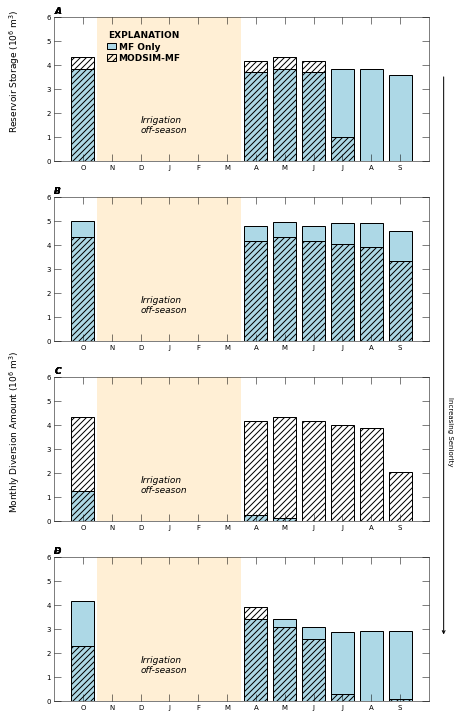

In [22]:
figwidth = 85  # mm
figwidth = figwidth / 10 / 2.54  # convert to inches
handletextpad = 0.1
markerscale = 1
handlelength = 1.25
columnspacing = 0.5
labelspacing = 0.25

working_dir1 = "modsim"
working_dir2 = "modflow6_only"

pkdat = []
with open(os.path.join(ws, working_dir1, "sfr_pakdata.in"), "r") as f:
    for line in f:
        m_arr = line.strip().split()
        pkdat.append(m_arr)

# create an integer array for location of mainstem
main_riv = np.zeros((len(pkdat)), dtype=int)
for x, itm in enumerate(pkdat):
    if "Mainstem" in itm[15]:
        i = int(itm[0]) - 1
        m_arr = itm[15].strip().split("_")
        main_riv[i] = m_arr[1]


sfr_flow_all = "gwf_modsim.sfr.bud"
sfr_flow = bf.CellBudgetFile(
    os.path.join(working_dir1, sfr_flow_all), precision="double"
)

ckstpkper = sfr_flow.get_kstpkper()
strm_Q = []
for i, kstpkper in enumerate(ckstpkper):
    strm_Q_step = sfr_flow.get_data(kstpkper=kstpkper, text="    FLOW-JA-FACE")
    strm_Q.append(strm_Q_step)
    print("Finished retrieving flows for stress period " + str(i + 1))


strm_gw = []
for i, kstpkper in enumerate(ckstpkper):
    strm_gw_step = sfr_flow.get_data(
        kstpkper=kstpkper, text="             GWF"
    )
    strm_gw.append(strm_gw_step)
    print(
        "Finished retrieving gw/sw interaction for stress period " + str(i + 1)
    )

# Loop for each time step, then for each reach on the main river
main_riv_flowing = np.zeros((len(strm_Q), len(pkdat)))
strm_Q_vals = np.zeros((len(strm_Q), len(pkdat)))
for tm in range(len(strm_Q)):
    cur_stp = strm_Q[tm][0]
    # remember that entries in cur_stp will be indexed by fortran and therefore 1-based
    itms = [
        entry
        for entry in cur_stp
        if (
            main_riv[(entry[0] - 1)] >= 1
            and main_riv[(entry[1] - 1)] >= 1
            and entry[1] > entry[0]
        )
    ]
    for i, itm in enumerate(itms):
        if abs(itm[2]) > 0:  # This condition would mean the stream is flowing
            main_riv_flowing[tm, (itm[0] - 1)] = 1
            strm_Q_vals[tm, (itm[0] - 1)] = abs(itm[2])


strm_gw_vals = np.zeros((len(strm_gw), len(pkdat)))
for tm in range(len(strm_gw)):
    cur_stp = strm_gw[tm][0]
    # remember that entries in cur_stp will be indexed by fortran and therefore 1-based
    itms = [entry for entry in cur_stp if main_riv[(entry[0] - 1)] >= 1]
    for i, itm in enumerate(itms):
        if abs(itm[2]) > 0:  # This condition would mean the stream is flowing
            strm_gw_vals[tm, (itm[0] - 1)] = itm[2]


q_dat = pd.DataFrame({"rno": np.arange(len(pkdat))})
gw_dat = q_dat.copy()

df_strmQ = pd.concat([pd.Series(x) for x in strm_Q_vals], axis=1)
df_strmQ.insert(0, "rno", np.arange(len(pkdat)))
df_strmQ.insert(1, "main_riv", main_riv)
df_gwsw = pd.concat([pd.Series(x) for x in strm_gw_vals], axis=1)
df_gwsw.insert(0, "rno", np.arange(len(pkdat)))
df_gwsw.insert(1, "main_riv", main_riv)


gwsw = []
for i in np.arange(len(strm_gw)):
    dat = df_gwsw.groupby(["main_riv"])[i].sum()
    gwsw.append(dat[1:].tolist())

gwsw = np.array(gwsw)
string = "Mainstem_"
cols = [string + str(i) for i in np.arange(1, 14)]
df_gwsw = pd.DataFrame(gwsw, columns=cols)
dates = pd.date_range(start="1989-09-30", end="1990-09-29")
df_gwsw.insert(0, "Date", dates)
df_gwsw.index = pd.to_datetime(df_gwsw["Date"], format="%y-%m-%d")
df_gwsw["YearMonth"] = pd.to_datetime(df_gwsw["Date"]).apply(
    lambda x: "{year}-{month}".format(year=x.year, month=x.month)
)
gwsw_time = df_gwsw.groupby("YearMonth")[cols].sum()

# Read in diversion amounts
fname = "gwf_modsim.sfrobs"

# Read in results from the two different models
ms_mf6_q = pd.read_csv(os.path.join(ws, working_dir1, fname), header=0)
mf6_q = pd.read_csv(os.path.join(ws, working_dir2, fname), header=0)
# drop the last row of the pandas dataframe associated with the MODFLOW 6 only run
mf6_q = mf6_q.iloc[:-1 , :]

ms_mf6_q.insert(0, "Date", dates[0 : (len(dates))])
mf6_q.insert(0, "Date", dates)

# Some dataframe manipulation
ms_mf6_q["Year"] = pd.to_datetime(ms_mf6_q["Date"]).apply(
    lambda x: "{year}".format(year=x.year)
)
mf6_q["Year"] = pd.to_datetime(ms_mf6_q["Date"]).apply(
    lambda x: "{year}".format(year=x.year)
)
ms_mf6_q["Month"] = pd.to_datetime(mf6_q["Date"]).apply(
    lambda x: "{month}".format(month=x.month)
)
mf6_q["Month"] = pd.to_datetime(mf6_q["Date"]).apply(
    lambda x: "{month}".format(month=x.month)
)
ms_mf6_q.drop([0], inplace=True)
mf6_q.drop([0], inplace=True)

div_cols = ["AGAREA1_DIV", "AGAREA2_DIV", "AGAREA3_DIV", "AGAREA4_DIV"]
ms_mf6_divs = ms_mf6_q.groupby(["Year", "Month"])[div_cols].sum()
mf6_divs = mf6_q.groupby(["Year", "Month"])[div_cols].sum()

patterns = ["/", "////", "\\", "|", "-", "+", "x", "o", "O", ".", "*"]

width, height = 5, 50

verts = [
    (0.5, 0.0),  # left, bottom
    (0.5, 80.0),  # left, top
    (5.5, 80.0),  # right, top
    (5.5, 0.0),  # right, bottom
    (0.0, 0.0),  # ignored
]
codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]
path = Path(verts, codes)


left = 0.125  # the left side of the subplots of the figure
right = 0.925  # the right side of the subplots of the figure
bottom = 0.025  # the bottom of the subplots of the figure
top = 0.975  # the top of the subplots of the figure
wspace = 0.2  # the amount of width reserved for blank space between subplots
hspace = 0.25  # the amount of height reserved for white space between subplots

dt1 = "1989-10-01"
dt2 = "1989-10-14"
dts = (
    pd.date_range(start=dt1, periods=12, freq="MS")
    + pd.DateOffset(days=datetime.strptime(dt2, "%Y-%m-%d").day)
).strftime("%Y-%m-%d")

figure_size = (6.5, 10)

fig, axes = plt.subplots(
    4,
    sharex=False,
    sharey=False,
    figsize=figure_size,
)
plt.subplots_adjust(
    left=left,
    bottom=bottom,
    right=right,
    top=top,
    wspace=wspace,
    hspace=hspace,
)


# common axes components for B - D
for ax in axes[0:]:
    ax.set_ylim(0, 6)
    patch = patches.PathPatch(path, facecolor="papayawhip", lw=0)
    ax.add_patch(patch)
    fs.add_text(
        ax,
        text="Irrigation\noff-season",
        x=2,
        y=1.5,
        va="center",
        transform=False,
        bold=False,
        italic=True,
    )
    ax.set_xticks(np.arange(12))
    ax.set_xticklabels(
        ["O", "N", "D", "J", "F", "M", "A", "M", "J", "J", "A", "S"]
    )
    # Add A, B, C, and D
    for idx, ax in enumerate(axes):
        fs.heading(ax, idx=idx)


# Ag Area 1
ax = axes[0]
ax.bar(
    np.arange(12),
    mf6_divs["AGAREA1_DIV"] / 1000000,
    color="lightblue",
    edgecolor="black",
    label="MF Only",
)
ax.bar(
    np.arange(12),
    ms_mf6_divs["AGAREA1_DIV"] / 1000000,
    fill=False,
    edgecolor="black",
    hatch=patterns[1],
    label="MODSIM-MF",
)
fs.graph_legend(
    ax,
    ncol=1,
    bbox_to_anchor=(0.12, 0.96),
    loc="upper left",
    labelspacing=0.25,
    columnspacing=0.25,
    markerscale=0.35,
    handlelength=1.,
    handletextpad=0.25,
)

# Ag Area 2
ax = axes[1]
ax.bar(
    np.arange(12),
    mf6_divs["AGAREA2_DIV"] / 1000000,
    color="lightblue",
    edgecolor="black",
    label="MF6 Only",
)
ax.bar(
    np.arange(12),
    ms_mf6_divs["AGAREA2_DIV"] / 1000000,
    fill=False,
    edgecolor="black",
    hatch=patterns[1],
    label="MODSIM-MF6",
)

# Ag Area 3
ax = axes[2]
ax.bar(
    np.arange(12),
    mf6_divs["AGAREA3_DIV"] / 1000000,
    color="lightblue",
    edgecolor="black",
    label="MF6 Only",
)
ax.bar(
    np.arange(12),
    ms_mf6_divs["AGAREA3_DIV"] / 1000000,
    fill=False,
    edgecolor="black",
    hatch=patterns[1],
    label="MODSIM-MF6",
)

# Ag Area 4
ax = axes[3]
ax.bar(
    np.arange(12),
    mf6_divs["AGAREA4_DIV"] / 1000000,
    color="lightblue",
    edgecolor="black",
    label="MF6 Only",
)
ax.bar(
    np.arange(12),
    ms_mf6_divs["AGAREA4_DIV"] / 1000000,
    fill=False,
    edgecolor="black",
    hatch=patterns[1],
    label="MODSIM-MF6",
)
fs.heading(ax, idx=4)

fig.text(
    0.04,
    0.9,
    "Reservoir Storage (10$^6$ m$^3$)",
    ha="center",
    va="center",
    rotation="vertical",
    fontsize=9,
)
fig.text(
    0.04,
    0.4,
    "Monthly Diversion Amount (10$^6$ m$^3$)",
    ha="center",
    va="center",
    rotation="vertical",
    fontsize=9,
)
axes[1].annotate(
    "",
    xy=(1.04, 1.85),
    xycoords="axes fraction",
    xytext=(1.04, -2.05),
    arrowprops=dict(arrowstyle="<-", color="k"),
)
fig.text(
    0.97, 0.4, "Increasing Seniority", ha="center", va="center", rotation=-90
)
